In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchtext import data, datasets
import torch.nn.functional as F
import torch.optim as O
from model import LSTMSentiment
from data_utils import load_sst, makedirs, get_args
from train import get_accuracy, train_model
from logit import load_sst_logistic_reg, logit_clf
from CD import CD, get_batches
import time

             precision    recall  f1-score   support

   positive       0.82      0.80      0.81       428
   negative       0.81      0.83      0.82       444

avg / total       0.82      0.82      0.82       872

0.8188073394495413


C:\Users\David\Anaconda3\envs\pytorch\lib\site-packages\torch\cuda\__init__.py:116: UserWarning: 
    Found GPU0 GeForce GTX 960M which is of cuda capability 5.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [2]:
args = get_args()
torch.cuda.set_device(0)
inputs, outputs, train_iter, valid_iter, train_sst, valid_sst = load_sst(args)
args["n_embed"] = len(inputs.vocab)
args["d_out"] = len(outputs.vocab)


In [3]:
# model = train_model(train_iter, valid_iter, inputs, outputs, args)
model = LSTMSentiment(args)
model.cuda()
model.load_state_dict(torch.load("results/best_snapshot.pt"))

In [4]:
args = get_args()
args["n_embed"] = len(inputs.vocab)
args["d_out"] = len(outputs.vocab)

torch.cuda.set_device(-1)
train, valid, test = load_sst_logistic_reg(args)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

vectorizer = CountVectorizer(tokenizer= lambda doc:doc, lowercase=False)

training_data = [text for text in train.text]
training_labels = [label for label in train.label]
validation_data = [text for text in valid.text]
validation_labels = [label for label in valid.label]
test_data = [text for text in test.text]
test_labels = [label for label in test.label]


bag_of_words = vectorizer.fit_transform(training_data)


clf = LogisticRegression(dual=True)
clf.fit(bag_of_words, training_labels)
predictions = clf.predict(vectorizer.transform(validation_data))

print(metrics.classification_report(validation_labels, predictions,target_names=["positive","negative"]))
print(metrics.accuracy_score(validation_labels, predictions))

             precision    recall  f1-score   support

   positive       0.82      0.80      0.81       428
   negative       0.81      0.83      0.82       444

avg / total       0.82      0.82      0.82       872

0.8188073394495413


In [6]:
validation_vectorizer = CountVectorizer(tokenizer = lambda doc:doc, lowercase=False)
validation_vectorizer.fit_transform(validation_data)
word_coef_lookup = {feature: coef for coef, feature in zip(clf.coef_[0], vectorizer.get_feature_names())}
word_validation_coef_lookup = {word:word_coef_lookup[word] for word in validation_vectorizer.vocabulary_ if word in word_coef_lookup}

In [7]:
batch_nums = list(range(6920))
data = get_batches(batch_nums, train_iter, valid_iter, dset='valid') 
cd = CD(model, inputs, clf, data)

getting batches...


In [16]:
from IPython.display import display_html
good_ones = [60, 15, 16]
num = 12
print("Review level CD scores")
res_review = cd.CD_phrase(cd.dissenting[num])
print()
print("Word level CD scores")
res_by_word = cd.CD_word(cd.dissenting[num])


Review level CD scores
-1.6768407809395087 The actors must indeed be good to recite some of this laughable dialogue with a straight face .

Word level CD scores
0.019606796909663674 The
0.10882711372195703 actors
0.007196564429978314 must
-0.20953339549013755 indeed
0.018140155473545184 be
0.27340320424563364 good
-0.08969720911153434 to
-0.09905964262655911 recite
-0.18313522558965448 some
0.024264198404860146 of
-0.0791504745254585 this
-1.9149970788454764 laughable
0.18005383269382352 dialogue
0.2795386097826924 with
0.13346048359899293 a
-0.638418881362188 straight
0.730443095553476 face
0.0034727560167528353 .


In [12]:
words = {}
if os.path.isfile("CD_SCORE_individual.csv"):
    df = pd.read_csv("CD_SCORE_individual.csv", index_col=0)
    words = {row["word"]:row["score"] for index, row in df.iterrows()} 
else:
    #Array of phrases
    for ind in range(len(data)):
        if ind%50 ==0:
            print("ind", ind)
        text = data[ind].text.data[:, 0]
        vect2Word = [inputs.vocab.itos[i] for i in text]
    #     print (vect2Word)
        for i in range(len(vect2Word)):
            if(vect2Word[i] not in words):
                words[vect2Word[i]] = cd.context_decomp(data[ind], i, i)
    df = pd.DataFrame(list(words.items()), columns=["word", "score"])
    df.to_csv("CD_SCORE_individual.csv")

(0.48990852081336883, 1.0078675505339225e-212)


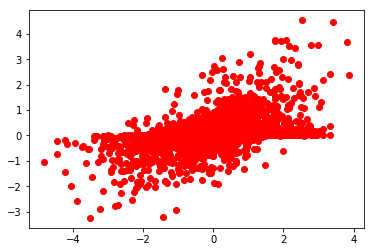

In [14]:
import matplotlib.pyplot as plt
import scipy as sp

x=[]
y=[]

for key, val  in word_validation_coef_lookup.items():
    if key in words:
        x.append(word_validation_coef_lookup[key])
        y.append(words[key])
    
print(sp.stats.pearsonr(x,y))
# y_10 = [y * 10 for elem in y]
plt.plot(x , y, 'ro')
plt.show()

In [15]:
import nltk
from nltk.tree import Tree

ROOT = 'ROOT'

negation_terms = set(['not', 'n’t', 'lacks', 'nobody', 'nor', 'nothing', 'neither', 'never', 'none', 'nowhere', 'remotely'])
parents_set = list()



trees = []
with open(os.path.expanduser('./.data/sst/trees/train.txt')) as f:
    for line in f:
        tree = Tree.fromstring(line)
        trees.append(tree)

def getNegatingSubphrases(parent, review_id, review, parent_index, tree_height):
    nodes = [{"node":node} for node in parent]
    start_index = parent_index
  
  # Get the start and end indexes for each child based off of their parent's index. 
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            end_index = len(node["node"].leaves()) + start_index
            node['start_index'] = start_index
            node['end_index'] = end_index
            start_index = end_index
      
    if len(parent.leaves()) > 10:
        if len(nodes) >= 2:
            first_child = nodes[0]['node']
            second_child = nodes[1]['node']

            first_child_first_two_words = set(list(first_child.leaves())[:2])
            # if the first child has some negation terms
            if first_child_first_two_words.intersection(negation_terms):
                if int(second_child.label()) in [0,1,3,4]:
                    parents_set.append({"review_id":review_id,"review":review, 
                                      "parent":parent, 
                                      "first_child": first_child, 
                                      "second_child":second_child, 
                                      "first_child_start_index":nodes[0]['start_index'],
                                      "first_child_end_index":nodes[0]['end_index'],
                                      "second_child_start_index": nodes[1]['start_index'],
                                      "second_child_end_index": nodes[1]['end_index'],
                                      "height":tree_height
                                     })

  # keep on recursing 
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            getNegatingSubphrases(node['node'], review_id, review, node['start_index'], tree_height + 1)

for i, tree in enumerate(trees):
    getNegatingSubphrases(tree, i, tree, 0,0)

    

In [17]:
negative_labels = set([0,1])
positive_labels = set([3,4])

dissenting_subphrase_reviews = []
def getDissentingSubphrase(parent, review_label, review_length, review, review_id,parent_index, tree_height):
    continue_recursion = True

    nodes = [{"node":node} for node in parent]
    start_index = parent_index

    # Get the start and end indexes for each child based off of their parent's index. 
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            end_index = len(node["node"].leaves()) + start_index
            node['start_index'] = start_index
            node['end_index'] = end_index
            start_index = end_index
  
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            node_label = int(node['node'].label())
            node_length = len(node['node'].leaves())
            if ((review_label in negative_labels and node_label in positive_labels) or (review_label in positive_labels and node_label in negative_labels)):
                if (review_length / float(3)) < node_length and (review_length * 2.0 / float(3)) > node_length:
                    dissenting_subphrase_reviews.append({"review_id":review_id,
                                                       "review":review, 
                                                       "parent":parent,
                                                       "child_start_index":node['start_index'],
                                                       "child_end_index":node['end_index'],
                                                       "dissenting_subphrase": node['node'],
                                                       "height":tree_height})
   
  

    for node in nodes:
        if type(node['node']) is nltk.Tree:
            getDissentingSubphrase(node['node'], review_label, review_length, review, review_id, node['start_index'], tree_height+1)
          
  
            
for i,tree in enumerate(trees):
    getDissentingSubphrase(tree, int(tree.label()), len(tree.leaves()), tree, i, 0, 0)

In [18]:
review_lookup = {}
#Array of phrases
for ind in range(len(data)):
    text = data[ind].text.data[:, 0]
    vect2Word = tuple(inputs.vocab.itos[i] for i in text)
    review_lookup[vect2Word] = data[ind]

In [19]:
dissenting_subphrase_cd_scores = []
dissenting_subphrase_labels = [] 
for review in dissenting_subphrase_reviews:
    review_vector = review_lookup[tuple(review['review'].leaves())]
    dissenting_subphrase_cd_score = cd.context_decomp(review_vector, review['child_start_index'],review['child_end_index'])
    subphrase_label = review['dissenting_subphrase'].label()
    dissenting_subphrase_cd_scores.append(dissenting_subphrase_cd_score)
    dissenting_subphrase_labels.append(subphrase_label)  

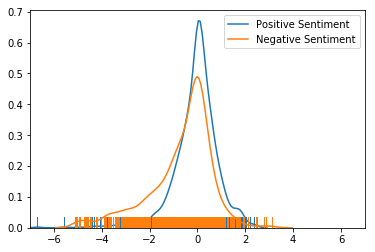

In [24]:
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns

results = zip(dissenting_subphrase_cd_scores, dissenting_subphrase_labels)
positive_subphrase_cd_scores = [score for score, label in results if int(label) in [3,4]]
results = zip(dissenting_subphrase_cd_scores, dissenting_subphrase_labels)
negative_subphrase_cd_scores = [score for score, label in results if int(label) in [0,1]]

x = np.asarray(positive_subphrase_cd_scores)
x2 = np.asarray(negative_subphrase_cd_scores)
plt.xlim(-7, 7)
sns.distplot(x,hist=False, rug=True, label="Positive Sentiment")
sns.distplot(x2,hist=False, rug=True, label="Negative Sentiment")
plt.legend()
plt.show()

In [25]:
review = dissenting_subphrase_reviews[2]
data_batch = review_lookup[tuple(review["review"].leaves())]
cd.CD_subphrases(data_batch, review['child_start_index'],review['child_end_index'])

[('What', 0.1426796571555212),
 ("`` Empire '' lacks in depth it", -1.0543872462195654),
 ('makes up for with its heart .', 1.0689462045129605)]